# Notebook 3: Lowest Order Rising Bubble

This notebook will demonstrate the use of the lowest-order finite element spaces. To increase the order of accuracy of the transport schemes we use a recovered finite element method where the transported fields are recovered into a higher-order function space before the transport is performed.

We will demonstrate this 'recovery' concept by solving the compressible Euler equations to simulate a rising bubble, using the dry test of Bryan and Fritsch (2002): https://journals.ametsoc.org/view/journals/mwre/130/12/1520-0493_2002_130_2917_absfmn_2.0.co_2.xml.

As usual, we begin by importing the required functions from Firedrake and Gusto:

In [1]:
from gusto import *
from firedrake import (IntervalMesh, ExtrudedMesh,
                       SpatialCoordinate, conditional, cos, pi, sqrt,
                       TestFunction, dx, TrialFunction, Constant, Function,
                       LinearVariationalProblem, LinearVariationalSolver)

INFO     Running /Users/JS1075/firedrake_dec24/lib/python3.12/site-packages/ipykernel_launcher.py -f /private/var/folders/f0/llvlmlb50qg6mmlxs8m6d6d00000gp/T/tmpeb131bow.json --HistoryManager.hist_file=:memory:


We now define the time-step size and simulation time.

In [2]:
dt = 1.0
tmax = 1000.

We will contruct our two dimensional mesh by extruding a 1D `IntervalMesh`. Here we specify the width and height of the mesh and the grid size `deltax` which is the same in both the x and z directions.

In [3]:
domain_width = 10000.
domain_height = 10000.
deltax = 100.
nlayers = int(domain_height/deltax)
ncolumns = int(domain_width/deltax)
m = IntervalMesh(ncolumns, domain_width)
mesh = ExtrudedMesh(m, layers=nlayers, layer_height=domain_height/nlayers)

We will record the full velocity and perturbations to the potential temperature.

In [4]:
domain = Domain(mesh, dt, family='CG', degree=0)
params = CompressibleParameters()
eqns = CompressibleEulerEquations(domain, params,
                                  u_transport_option="vector_advection_form",
                                  no_normal_flow_bc_ids=[1, 2])

In [5]:
dirname = 'lowest_order_bubble'
output = OutputParameters(dirname=dirname, dumplist=['u'])
diagnostic_fields = [Perturbation('theta')]
io = IO(domain, output, diagnostic_fields=diagnostic_fields)

We now set-up the transport schemes and some options required for the recovery scheme. We will use discontinuous elements for the lower order 'embedded' space and continuous elements for the higher order 'recovered' space. 

In [6]:
boundary_methods = {'DG': BoundaryMethod.taylor,
                    'HDiv': BoundaryMethod.taylor}

recovery_spaces = RecoverySpaces(
    domain, boundary_methods, use_vector_spaces=True
)

u_opts = recovery_spaces.HDiv_options
rho_opts = recovery_spaces.DG_options
theta_opts = recovery_spaces.theta_options

transported_fields = [
    SSPRK3(domain, "rho", options=rho_opts),
    SSPRK3(domain, "theta", options=theta_opts),
    SSPRK3(domain, "u", options=u_opts)
]

transport_methods = [
    DGUpwind(eqns, field) for field in ["u", "rho", "theta"]
]

linear_solver = CompressibleSolver(eqns)

stepper = SemiImplicitQuasiNewton(
    eqns, io, transported_fields, transport_methods,
    linear_solver=linear_solver
)

INFO     Physical parameters that take non-default values:


INFO     


In [7]:
u0 = stepper.fields("u")
rho0 = stepper.fields("rho")
theta0 = stepper.fields("theta")

Vt = domain.spaces("theta")
Vr = domain.spaces("DG")

xz = SpatialCoordinate(mesh)
Tsurf = 300.0
theta_b = Function(Vt).interpolate(Constant(Tsurf))

# Calculate hydrostatic fields
compressible_hydrostatic_balance(eqns, theta_b, rho0, solve_for_rho=True)

# make mean fields
rho_b = Function(Vr).assign(rho0)

# define perturbation
xc = domain_width / 2
zc = 2000.
rc = 2000.
Tdash = 2.0
r = sqrt((xz[0] - xc) ** 2 + (xz[1] - zc) ** 2)
theta_pert = Function(Vt).interpolate(
    conditional(r > rc, 0.0, Tdash * (cos(pi * r / (2.0 * rc))) ** 2)
)

# define initial theta
theta0.interpolate(theta_b * (theta_pert / 300.0 + 1.0))

# find perturbed rho
gamma = TestFunction(Vr)
rho_trial = TrialFunction(Vr)
lhs = gamma * rho_trial * dx
rhs = gamma * (rho_b * theta_b / theta0) * dx
rho_problem = LinearVariationalProblem(lhs, rhs, rho0)
rho_solver = LinearVariationalSolver(rho_problem)
rho_solver.solve()

stepper.set_reference_profiles([('rho', rho_b), ('theta', theta_b)])

Specify the density mean field and intial temperature

Find the perturbation density by solving a separate linear system. 

In [8]:
gamma = TestFunction(Vr)
rho_trial = TrialFunction(Vr)
lhs = gamma * rho_trial * dx
rhs = gamma * (rho_b * theta_b / theta0) * dx
rho_problem = LinearVariationalProblem(lhs, rhs, rho0)
rho_solver = LinearVariationalSolver(rho_problem)
rho_solver.solve()

Set up the linear solver and the time-stepper.

Now, we can run the simulation.

In [9]:
# Here's what you would do:
# stepper.run(t=0, tmax=tmax)

We can input the results into Paraview and look at the temperature over the simulation. As expected, the bubble rises over time.

t = 0 s
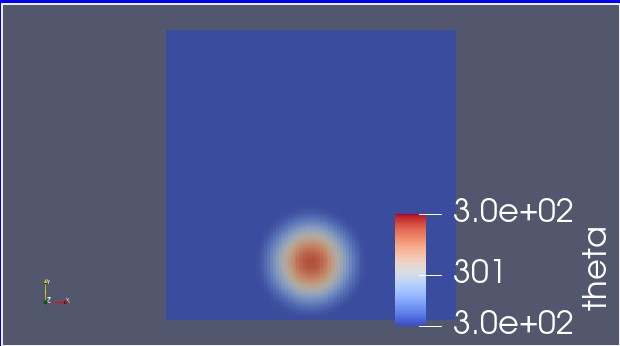

t = 600 s
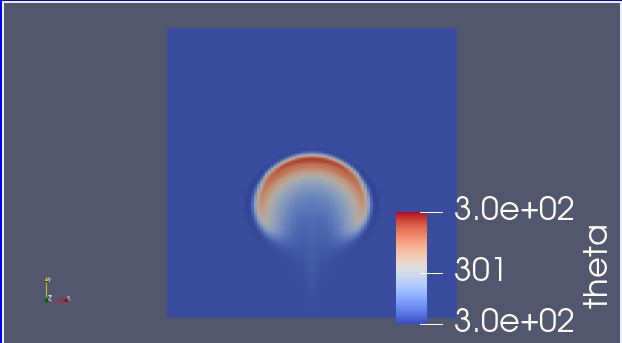

t = 1000 s
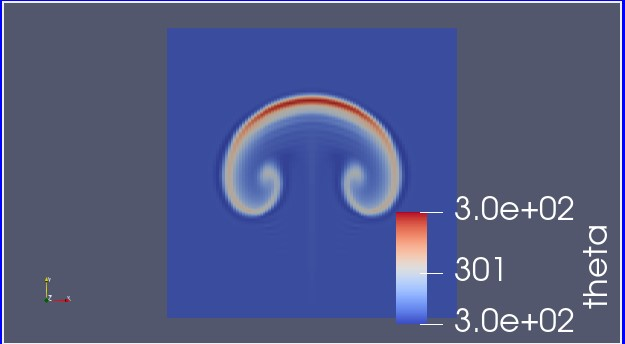